In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from EDA_tools import DfAnalysis, DataPreprocessing

from sklearn.neighbors import BallTree
from sklearn.cluster import DBSCAN

from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

import os
from joblib import dump

import warnings
warnings.filterwarnings('ignore')

In [2]:
agence = pd.read_csv(r"data\agence.csv")
france = pd.read_csv(r"data\france.csv")
insee_commune = pd.read_csv(r"data\insee_commune.csv")
localisation_commune = pd.read_csv(r"data\localisation_commune.csv")
map_code_insee = pd.read_csv(r"data\map_code_insee.csv")

## Construction du dataset d'étude

Nous disposons de plusieurs datasets (agence, france, insee_commune, localisation), il serait intéressant de les combiner de telle sorte à pouvoir en extraire les données essentielles lors d'une EDA plus approfondie mais surtout afin de le fournir à nos modèles de machine learning que nous implémenterons dans un second jupyter notebook.

Nous utiliserons notamment deux fichiers `DimRed_plus` et `EDA_tools` qui proposent certaines fonctionnalités d'automatisation de graphiques, d'étapes de preprocessing des données etc...

## Sommaire

Au cours de ce notebook Jupyter, nous entreprendrons les étapes suivantes pour enrichir notre jeu de données initial (`agence.csv`) avec des informations provenant d'autres fichiers afin de mieux correspondre au profil client et d'étudier l'impact de la performance des agents immobiliers sur la détermination de la valeur foncière des biens immobiliers en Haute-Garonne :

1. **Analyse rapide du fichier agence.csv** :
   - Exploration initiale des données pour comprendre leur structure et leur contenu.

2. **Fusion avec le fichier france.csv** :
   - Intégration des données sur la France pour enrichir notre jeu de données.

3. **Analyse du fichier insee_commune.csv** :
   - Exploration des données de l'INSEE sur les communes pour obtenir des informations supplémentaires.

4. **Fusion entre les fichiers insee_commune.csv et localisation_commune.csv** :
   - Combinaison des données de localisation des communes avec les données de l'INSEE pour une meilleure compréhension géographique.

5. **Analyse des corrélations entre les variables** :
   - Identification des relations et des dépendances entre les différentes caractéristiques du jeu de données.

6. **Sélection manuelle des variables** :
   - Choix des variables pertinentes à inclure dans notre modèle.

7. **Préparation d'un jeu de données pour le machine learning** :
   - Transformation des données en un format adapté à l'apprentissage automatique.

8. **Test avec un premier modèle CatBoost** :
   - Mise en œuvre d'un modèle de prédiction basé sur l'algorithme CatBoost pour évaluer sa performance dans la prédiction de la valeur foncière des biens immobiliers.

À travers ces étapes, nous visons à améliorer la qualité de notre jeu de données, à identifier les facteurs clés influençant la valeur foncière et à construire un modèle prédictif robuste pour soutenir nos analyses futures.

## Etapes 1, 2

In [3]:
agence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_mutation              4000 non-null   object 
 1   valeur_fonciere            4000 non-null   float64
 2   code_postal                4000 non-null   int64  
 3   nom_commune                4000 non-null   object 
 4   id_parcelle                4000 non-null   object 
 5   type_local                 4000 non-null   object 
 6   surface_reelle_bati        4000 non-null   float64
 7   surface_terrain            4000 non-null   float64
 8   nombre_pieces_principales  4000 non-null   float64
 9   agent                      4000 non-null   int64  
 10  prixcible                  4000 non-null   int64  
 11  prixvente_initial          4000 non-null   int64  
 12  evaluation_agent           4000 non-null   object 
dtypes: float64(4), int64(4), object(5)
memory usage:

Dans un premier temps:
- Nous effectuons la conversion de type des dates 
- Nous vérifions les valeurs manquantes dans le dataset en créant une instance de `DfAnalysis`
    - Nous ajouterons le préfixe 'dan' pour différencier cette instance du dataset original

Note: l'étude complète (outliers, corrélations...) du dataset interviendra plus tard

In [4]:
agence['date_mutation'] = pd.to_datetime(agence['date_mutation'], format='%Y-%m-%d')

In [5]:
dan_agence = DfAnalysis(agence)
dan_agence.missing_values_check()
print(50*'-')
dan_agence.duplicate_check()

4000 row(s) have 0 missing values
Total number of rows with missing values: 0
List of indexes of rows with missing values: []
--------------------------------------------------
No duplicated rows


Dans un second temps: 
- Nous ne sélectionnons que la plage de données de `france.csv` concernant la haute garonne

`france.csv` est un dataset intéressant en ce qu'il réunit des informations relatives au carreau d'appartenance des biens considérés (un carreau est une unité de 200m de côté sur laquelle peuvent être considérées des variables comme la densité de population, le niveau de vie des ménages etc...): ceci en fait un dataset très fin et dons utile pour notre étude

In [6]:
france['code_postal'] = france['code_postal'].astype(str)
france_HG = france[france['code_postal'].str.startswith('31')]
france_HG.sample(2)

,date_mutation,valeur_fonciere,adresse_code_voie,code_postal,nom_commune,code_commune,id_parcelle,type_local,surface_reelle_bati,surface_terrain,...,carreau_Ind_11_17,carreau_Ind_18_24,carreau_Ind_25_39,carreau_Ind_40_54,carreau_Ind_55_64,carreau_Ind_65_79,carreau_Ind_80p,carreau_Ind_inc,carreau_I_pauv,carreau_t_maille
659162,2017-10-02,240000.0,A002,31290,Renneville,31450,314500000B0867,Maison,100.0,911.0,...,26.7,6.0,22.0,55.4,23.1,16.0,5.1,5.5,0,2000
641969,2017-04-04,331480.0,0715,31490,Léguevin,31291,31291000AW0052,Maison,132.0,1077.0,...,323.0,200.4,615.0,837.1,502.0,244.2,82.8,166.9,0,2000


In [7]:
print('france_HG',france_HG.shape, '|', 'agence', agence.shape)

france_HG (57661, 46) | agence (4000, 13)


Nous effectuons quelques conversions de type

In [8]:
france_HG['date_mutation'] = pd.to_datetime(france_HG['date_mutation'], format='%Y-%m-%d')

On constate ici que les coordonnées géographiques de `france.csv` concernent les biens eux-mêmes cela peut nous donner des idées de combinaisons de features interessantes pour l'avenir:
- Distance du bien au centre ville de sa commune d'appartenance en utilisant `localisation_commune.csv`
- Distance du bien au centre ville de Toulouse

In [9]:
france_HG[['nom_commune', 'latitude', 'longitude']].head()

,nom_commune,latitude,longitude
42517,Bourbon-l'Archambault,46.600380,3.070512
42518,Bourbon-l'Archambault,46.597794,3.080006
42918,Bourbon-l'Archambault,46.586081,3.060649
42919,Bourbon-l'Archambault,46.585826,3.066112
42920,Bourbon-l'Archambault,46.579173,3.055870


In [10]:
france.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2641120 entries, 0 to 2641119
Data columns (total 46 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   date_mutation              object 
 1   valeur_fonciere            float64
 2   adresse_code_voie          object 
 3   code_postal                object 
 4   nom_commune                object 
 5   code_commune               object 
 6   id_parcelle                object 
 7   type_local                 object 
 8   surface_reelle_bati        float64
 9   surface_terrain            float64
 10  nombre_pieces_principales  float64
 11  longitude                  float64
 12  latitude                   float64
 13  departement                int64  
 14  index_right                int64  
 15  carreau_Id_carr_n          object 
 16  carreau_Ind                float64
 17  carreau_Men                float64
 18  carreau_Men_pauv           float64
 19  carreau_Men_1ind           float64
 20  ca

Afin de s'assurer de la correspondance parfaite entre les ventes réalisées par l'agence et celles entrées dans `france.csv` nous effectuons un inner merge sur l'identifiant de la parcelle concernée et sur la date de l'opération.

In [11]:
df_enriched1 = pd.merge(agence, france_HG, how='inner', on=['id_parcelle', 'date_mutation'])
df_enriched1.shape

(4000, 57)

Les colonnes communes sont désormais préfixées, il convient de retirer ces préfixes et de supprimer les colonnes dupliquées

In [12]:
(df_enriched1['nom_commune_x'] == df_enriched1['nom_commune_y']).all()

True

In [13]:
temp_df_enriched1 = DfAnalysis(df_enriched1.T)
temp_df_enriched1.duplicate_check()
df_enriched1 = temp_df_enriched1.df.T

df_enriched1.rename(columns={col: col.rsplit('_', 1)[0] for col in df_enriched1.columns if col.endswith('_x')}, inplace=True)

df_enriched1[['code_postal', 'code_commune']] # considérons code commune qui n'équivaut pas au code_postal
df_enriched1['code_commune'] = df_enriched1['code_commune'].astype(str)

There are 6 rows that are duplicated so we need to drop them
After dropping duplicated rows, there are 51 rows left


<font color="red">ATTENTION</font>: `code_commune` ne correspond pas au code postal de la commune mais à l'identifiant attribué par l'Insee à chaque commune de France


## Etapes 3, 4

Nous devons encore ajouter les variables de géolocalisation des communes (elles remplaceront leurs noms et leur code postal puisqu'elle sont uniques) et nous permettront de calculer la distance au centre ville de la commune de rattachement du bien ainsi que la distance au centre ville de toulouse (deux nouvelles features). 

- `insee_commune.csv` est un dataset essentiel pour notre étude car il contient des informations socio économiques relatives aux communes que l'on considèrera
- `localisation_commune.csv` est moins riche mais non moins intéressant: il contient notamment les coordonnées gps des centres ville des communes étudiées ici 

Encore une fois on sélectionne la plage de données concernant la Haute-Garonne

In [14]:
localisation_commune['Code_postal'] = localisation_commune['Code_postal'].astype(str)
mask = localisation_commune['Code_postal'].str.startswith('31')
localisation_commune_HG = localisation_commune[mask]

In [15]:
localisation_commune_HG['coordonnees_gps'].apply(lambda s: type(s)).unique()

array([<class 'str'>], dtype=object)

Nous séparons la colonne `coordonnees_gps` en deux nouvelles colonnes `latitude_comm` et 'longitude_comm' pour préciser qu'il s'agit des coordonnées du centre ville de la commune

In [16]:
localisation_commune_HG[['latitude_comm', 'longitude_comm']] = localisation_commune_HG['coordonnees_gps'].str.split(',', expand=True)

localisation_commune_HG['latitude_comm'] = pd.to_numeric(localisation_commune_HG['latitude_comm'], errors='coerce')
localisation_commune_HG['longitude_comm'] = pd.to_numeric(localisation_commune_HG['longitude_comm'], errors='coerce')

print(localisation_commune_HG[['latitude_comm', 'longitude_comm']])

       latitude_comm  longitude_comm
269        46.460771        2.559048
270        46.219967        3.249307
273        46.401575        2.730717
281        46.266258        3.229794
286        46.269689        3.423880
...              ...             ...
33986      43.663774        1.677386
33987      43.750880        1.490977
33988      43.406779        1.719651
33989      43.828733        1.496849
33990      43.134325        0.485144

[690 rows x 2 columns]


In [17]:
localisation_commune_HG.rename(columns={'Code_commune_INSEE': 'code_commune'}, inplace=True)

Nous ne nous donnons pas la peine de sélectionner les communes de la Haute-Garonne de `insee_commune.csv`, nous les obtiendrons naturellement lorsque nous fusionneront ce dataset avec `localisation_commune_HG.csv`

In [18]:
insee_commune.rename(columns={'CODGEO':'code_commune'}, inplace=True)

Nous nous séparons des variables parasites

In [19]:
localisation_commune_HG = localisation_commune_HG.drop(['Ligne_5',
       'Libellé_d_acheminement', 'Libell_d_acheminement', 'coordonnees_gps'], axis=1)

Nous fusionnons nos deux datasets sur ce fameux `code_commune`

In [20]:
df_enriched2 = pd.merge(insee_commune, localisation_commune_HG, how='inner', on='code_commune')

Nous vérifions que nos deux datasets ne disposent pas d'autres colonnes en commun que la colonne de fusion afin d'éviter de potentiels problèmes de dimension

In [21]:
df_enriched2.columns[(df_enriched2.columns.isin(df_enriched1.columns))]

Index(['code_commune'], dtype='object')

In [22]:
df_enriched2_unique = df_enriched2.drop_duplicates(subset=['code_commune'], keep='first')
print('df2 dropping duplicate for code_commune: ', df_enriched2_unique.shape)
print('df2: ', df_enriched2.shape)

df2 dropping duplicate for code_commune:  (674, 40)
df2:  (690, 40)


In [23]:
print(df_enriched1['code_commune'].apply(lambda s: type(s)).unique())
print(df_enriched2['code_commune'].apply(lambda s: type(s)).unique())

[<class 'str'>]
[<class 'str'>]


On vérifie que l'on peut bien se permettre de supprimer les index pour lesquels la valeur en `code_commune` est égale, il s'agit en fait que tout l'index est alors dupliqué, on peut donc le supprimer

In [24]:
doublons_mask = df_enriched2.duplicated(subset=['code_commune'], keep=False)
duplicate_rows = df_enriched2.loc[doublons_mask]
print(duplicate_rows.head(2))

   code_commune       LIBGEO  REG DEP  P16_POP  P11_POP  SUPERF  NAIS1116  \
46        03158  Haut-Bocage   84  03      892      965   70.64        33   
47        03158  Haut-Bocage   84  03      892      965   70.64        33   

    DECE1116     P16_MEN  ...  ETFZ15  ETGU15  ETGZ15  ETOQ15  ETTEF115  \
46        29  361.206154  ...     8.0    34.0     5.0    10.0      17.0   
47        29  361.206154  ...     8.0    34.0     5.0    10.0      17.0   

    ETTEFP1015  Nom_commune  Code_postal  latitude_comm  longitude_comm  
46         2.0  HAUT BOCAGE         3190      46.492864        2.658524  
47         2.0  HAUT BOCAGE         3190      46.492864        2.658524  

[2 rows x 40 columns]


Nous obtenons finalement notre dataset final en effectuant un merge left toujours sur le `code_commune` nous avons bien conservé la forme du dataset original, c'est bon signe:

In [25]:
df_final = pd.merge(df_enriched1, df_enriched2_unique, how='left', on='code_commune')

In [26]:
df_final.shape # df_final a une forme correcte, égale à celle d'agence_csv

(4000, 90)

## Etapes 5, 6

Nous devons éliminer quelques-unes des features qui ne sont pas pertinentes ou qui présentent des risques de data leakage 

In [27]:
print(f'Nous avons {df_final.shape[1]} features')

Nous avons 90 features


In [28]:
df_final_red = df_final

In [29]:
# data leakage / index du df de droite
df_final_red.drop(['prixcible', 'prixvente_initial', 'index_right'], axis=1, inplace=True) 

# features non pertinentes
df_final_red.drop(
    
    ['adresse_code_voie', 'code_commune','code_postal_y', 'nom_commune',
       'id_parcelle','LIBGEO', 'REG', 'DEP', 'Nom_commune','Code_postal', 
       'departement']
       
       , axis=1, inplace=True)

In [30]:
df_final_red.columns

Index(['date_mutation', 'valeur_fonciere', 'code_postal', 'type_local',
       'surface_reelle_bati', 'surface_terrain', 'nombre_pieces_principales',
       'agent', 'evaluation_agent', 'longitude', 'latitude',
       'carreau_Id_carr_n', 'carreau_Ind', 'carreau_Men', 'carreau_Men_pauv',
       'carreau_Men_1ind', 'carreau_Men_5ind', 'carreau_Men_prop',
       'carreau_Men_fmp', 'carreau_Ind_snv', 'carreau_Men_surf',
       'carreau_Men_coll', 'carreau_Men_mais', 'carreau_Log_av45',
       'carreau_Log_45_70', 'carreau_Log_70_90', 'carreau_Log_ap90',
       'carreau_Log_inc', 'carreau_Log_soc', 'carreau_Ind_0_3',
       'carreau_Ind_4_5', 'carreau_Ind_6_10', 'carreau_Ind_11_17',
       'carreau_Ind_18_24', 'carreau_Ind_25_39', 'carreau_Ind_40_54',
       'carreau_Ind_55_64', 'carreau_Ind_65_79', 'carreau_Ind_80p',
       'carreau_Ind_inc', 'carreau_I_pauv', 'carreau_t_maille', 'P16_POP',
       'P11_POP', 'SUPERF', 'NAIS1116', 'DECE1116', 'P16_MEN', 'NAISD18',
       'DECESD18', 'P16_L

Les données statistiques des carreaux sont des données numériques

In [31]:
carreau_to_numeric = [col for col in df_final_red.columns if col.startswith('carreau')]

df_final_red[carreau_to_numeric] = df_final_red[carreau_to_numeric].apply(pd.to_numeric, errors='coerce')

In [32]:
df_final_red['date_mutation'] = pd.to_datetime(df_final_red['date_mutation'], format='%Y-%m-%d')

In [33]:
df_final_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 76 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date_mutation              4000 non-null   datetime64[ns]
 1   valeur_fonciere            4000 non-null   object        
 2   code_postal                4000 non-null   object        
 3   type_local                 4000 non-null   object        
 4   surface_reelle_bati        4000 non-null   object        
 5   surface_terrain            4000 non-null   object        
 6   nombre_pieces_principales  4000 non-null   object        
 7   agent                      4000 non-null   object        
 8   evaluation_agent           4000 non-null   object        
 9   longitude                  4000 non-null   object        
 10  latitude                   4000 non-null   object        
 11  carreau_Id_carr_n          0 non-null      float64       
 12  carrea

Toutes les valeurs de `carreau_Id_carr_n` sont nulles, on supprime donc cette colonne

In [34]:
df_final_red.drop('carreau_Id_carr_n', axis=1, inplace=True)

Nous convertissons enfin les variables restantes

In [35]:
cols_to_numeric = ['valeur_fonciere', 'surface_reelle_bati',
                    'surface_terrain', 'nombre_pieces_principales',
                    'longitude', 'latitude']

df_final_red[cols_to_numeric] = df_final[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

In [36]:
df_final_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date_mutation              4000 non-null   datetime64[ns]
 1   valeur_fonciere            4000 non-null   float64       
 2   code_postal                4000 non-null   object        
 3   type_local                 4000 non-null   object        
 4   surface_reelle_bati        4000 non-null   float64       
 5   surface_terrain            4000 non-null   float64       
 6   nombre_pieces_principales  4000 non-null   float64       
 7   agent                      4000 non-null   object        
 8   evaluation_agent           4000 non-null   object        
 9   longitude                  4000 non-null   float64       
 10  latitude                   4000 non-null   float64       
 11  carreau_Ind                4000 non-null   float64       
 12  carrea

**Sélection de variable**

Nous commençons tout d'abord par générer la matrice des corrélations:
- (voir dossier img $\rightarrow$ correlation_matrix.png)
- Nous remarquons que de très nombreuses variables sont très fortement corrélées, il y a donc matière à sélection

In [37]:
dan_df_final_red = DfAnalysis(df_final_red)
dan_df_final_red.correlation_matrix() # beaucoup de variables sont fortement corrélées

Avant de sélectionner nos variables nous devons nous occuper des index pour lesquels des données manquent, nous pourrions: supprimer les index, remplir artificiellement les données manquantes avec filna s'il s'agit de données numériques ou supprimer les features concernées si celles-ci ne s'avèrent pas être d'un grand intérêt pour notre étude.

In [38]:
pd.set_option('display.max_columns', None)
cols_with_nan = df_final_red.loc[3786].isna()

# Afficher les noms des colonnes qui ont une valeur NaN pour cet index
print(cols_with_nan[cols_with_nan].index.tolist())

df_final_clean = df_final_red

df_final_clean.drop(['PIMP16', 'TP6016'], axis=1, inplace=True)

['PIMP16', 'TP6016']


`PIMP16`
Part des ménages fiscaux imposés (%)

`TP6016`
Taux de pauvreté-Ensemble (%)

On peut lire sur la matrice de corrélation que ces deux variables sont toutes deux très corrélées à au moins une autre variable (au delà de 75% en valeur absolue) on peut donc raisonnablement se permettre de les supprimer

**Feature engineering 1**

Nous ajoutons à présent les distances que nous avions mentionnées tout à l'heure

In [39]:
from math import radians, cos, sin, asin, sqrt

# On réimplémente à la main la distance de haversine dans le but de rappeler comment elle fonctionne

def distance(lat1, lat2, lon1, lon2):
	
	lon1 = radians(lon1)
	lon2 = radians(lon2)
	lat1 = radians(lat1)
	lat2 = radians(lat2)
	
	dlon = lon2 - lon1 
	dlat = lat2 - lat1
	a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2

	c = 2 * asin(sqrt(a)) 
	
	r = 6371

	return c*r

In [40]:
df_final_clean['distance_cv_km'] = df_final_clean.apply(
    lambda row: distance(row['latitude'],
                         row['latitude_comm'],
                         row['longitude'],
                         row['longitude_comm']),                    
    axis=1)

# Même chose sauf que l'on entre les coordonnées du centre ville de Toulouse
df_final_clean['distance_toulouse_km'] = df_final_clean.apply(
    lambda row: distance(row['latitude'],
                         43.603,
                         row['longitude'],
                         1.443), 
    axis=1)

df_final_clean.sample(4)

,date_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,surface_terrain,nombre_pieces_principales,agent,evaluation_agent,longitude,latitude,carreau_Ind,carreau_Men,carreau_Men_pauv,carreau_Men_1ind,carreau_Men_5ind,carreau_Men_prop,carreau_Men_fmp,carreau_Ind_snv,carreau_Men_surf,carreau_Men_coll,carreau_Men_mais,carreau_Log_av45,carreau_Log_45_70,carreau_Log_70_90,carreau_Log_ap90,carreau_Log_inc,carreau_Log_soc,carreau_Ind_0_3,carreau_Ind_4_5,carreau_Ind_6_10,carreau_Ind_11_17,carreau_Ind_18_24,carreau_Ind_25_39,carreau_Ind_40_54,carreau_Ind_55_64,carreau_Ind_65_79,carreau_Ind_80p,carreau_Ind_inc,carreau_I_pauv,carreau_t_maille,P16_POP,P11_POP,SUPERF,NAIS1116,DECE1116,P16_MEN,NAISD18,DECESD18,P16_LOG,P16_RP,P16_RSECOCC,P16_LOGVAC,P16_RP_PROP,NBMENFISC16,MED16,P16_EMPLT,P16_EMPLT_SAL,P11_EMPLT,P16_POP1564,P16_CHOM1564,P16_ACT1564,ETTOT15,ETAZ15,ETBE15,ETFZ15,ETGU15,ETGZ15,ETOQ15,ETTEF115,ETTEFP1015,latitude_comm,longitude_comm,distance_cv_km,distance_toulouse_km
3922,2016-05-04,213500.0,31700,Maison,85.0,263.0,4.0,4,Renove,1.277833,43.677351,598.5,248.9,20.0,59.9,6.1,122.0,33.9,14312276.5,20384.1,87.9,161.0,0.0,3.8,34.0,211.1,0.0,23.1,63.2,17.1,43.0,41.7,46.9,222.9,93.0,27.9,33.9,5.0,3.9,0,1000,2322,2031,16.88,179,53,931.357052,25,5,1040.449540,931.357052,15.012728,94.079760,670.734435,927.0,25374.347826,200.452556,151.170006,181.188041,1530.297332,84.579416,1255.905972,141.0,13.0,3.0,18.0,96.0,26.0,11.0,14.0,3.0,43.687253,1.266346,1.437204,15.652571
1973,2017-01-13,372000.0,31500,Maison,100.0,141.0,3.0,6,Renove,1.460258,43.619471,321.5,152.0,14.0,65.0,11.0,87.0,14.0,8728259.0,11744.0,78.0,74.0,76.0,29.0,35.0,12.0,0.0,0.0,11.0,7.0,22.0,23.0,16.5,69.0,77.0,35.0,33.0,22.0,6.0,0,200,475438,447340,118.30,32723,13350,255005.199016,6818,2791,288251.847787,255005.199016,9704.217289,23542.431482,83548.648751,206811.0,20430.000000,310260.709313,277402.642203,290807.949081,343833.496292,43697.422351,246491.091303,55138.0,82.0,1834.0,5047.0,38803.0,7663.0,9372.0,11871.0,3397.0,43.596381,1.431673,3.447986,2.298885
1676,2014-06-18,165000.0,31100,Appartement,45.0,134.0,3.0,2,Ancien,1.420154,43.588771,7896.5,4388.0,627.0,2292.0,103.0,1628.0,406.0,189661856.8,279665.0,3721.0,667.0,663.0,1257.0,578.0,1828.0,62.0,381.0,368.4,131.5,326.5,388.0,581.0,2572.0,1390.0,787.0,766.0,417.0,169.1,0,1000,475438,447340,118.30,32723,13350,255005.199016,6818,2791,288251.847787,255005.199016,9704.217289,23542.431482,83548.648751,206811.0,20430.000000,310260.709313,277402.642203,290807.949081,343833.496292,43697.422351,246491.091303,55138.0,82.0,1834.0,5047.0,38803.0,7663.0,9372.0,11871.0,3397.0,43.596381,1.431673,1.255664,2.426548
1794,2017-10-19,215000.0,31400,Appartement,69.0,69.0,3.0,2,Renove,1.457685,43.594450,684.0,345.0,46.0,151.0,9.0,171.0,29.0,18103201.2,23950.0,335.0,10.0,34.0,226.0,0.0,85.0,0.0,7.0,49.0,14.5,33.5,21.0,32.0,226.0,125.0,59.0,58.0,43.0,23.0,0,200,475438,447340,118.30,32723,13350,255005.199016,6818,2791,288251.847787,255005.199016,9704.217289,23542.431482,83548.648751,206811.0,20430.000000,310260.709313,277402.642203,290807.949081,343833.496292,43697.422351,246491.091303,55138.0,82.0,1834.0,5047.0,38803.0,7663.0,9372.0,11871.0,3397.0,43.596381,1.431673,2.105742,1.517308


<font color="red">Note:</font>

On remarque ici avec ces deux premières lignes qui sont relatives toutes deux à des ventes effectuées à Toulouse que la distance cv n'est pas la même que la distance toulouse mais diffèrent assez peu, on peut supposer que distance cv représente la distance au centre ville de l'arrondissement et que distance toulouse représente la distance au 'point zéro' de Toulouse. Ceci est d'autant plus intéressant que l'on peut à peu près en déduire les positions relatives des biens.

In [41]:
coordinates = df_final_clean[['latitude', 'longitude']]
list_clusters = []

dbscan = DBSCAN(eps=0.00008, min_samples=4, metric='haversine') # 0.00008 radians donne ~500m à la surface du globe
list_clusters = dbscan.fit_predict(np.radians(coordinates))

num_clusters = len(set(list_clusters)) - (1 if -1 in list_clusters else 0)
print(f"Nombre de clusters trouvés : {num_clusters}")

Nombre de clusters trouvés : 37


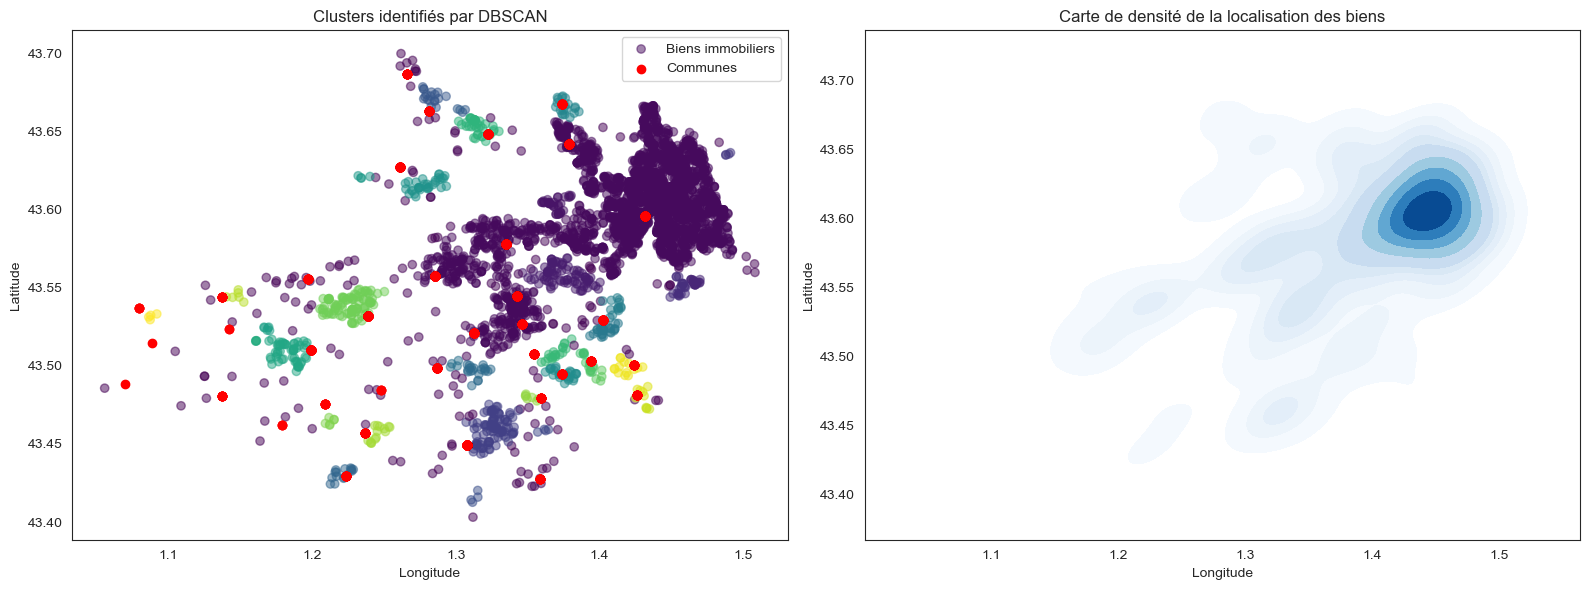

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

# Clusters identifiés par DBSCAN
axes[0].scatter(df_final_clean['longitude'], df_final_clean['latitude'], c=list_clusters, cmap='viridis', alpha=0.5, label='Biens immobiliers')
axes[0].scatter(df_final_clean['longitude_comm'], df_final_clean['latitude_comm'], c='r', label='Communes')
axes[0].set_title('Clusters identifiés par DBSCAN')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].legend()

# Carte de densité KDE
sns.kdeplot(x=df_final_clean['longitude'], y=df_final_clean['latitude'], cmap='Blues', fill=True, ax=axes[1])
axes[1].set_title('Carte de densité de la localisation des biens')
axes[1].set_xlabel('Longitude') 
axes[1].set_ylabel('Latitude')  

plt.tight_layout() 
plt.show()


Nous avons donc bien vérifié la pertinence des coordonnées géographiques de nos biens. Par ailleurs, en réglant finement l'algorithme DBSCAN, on obtient une performance plutôt bonne, nous permettant de distinguer environ une quarantaine de communes.

**Feature engineering 2**

Comment un agent immobilier procède-t-il usuellement pour déterminer le prix d'un bien? Il analyse le prix moyen de ses plus proches voisins géographiques! Nous allons donc utiliser un algorithme de type balltree qui récupèrera les 10 plus proches voisins d'un bien ou du moins le maximum de voisins dans un périmètre de 200m (de sorte que l'on appartienne au même carreau) et qui soient (si possible) des biens du même type, c'est à dire dans le même état et même catégorie de logement (appartement ou maison).

In [43]:
# ATTENTION on convertit les colonnes en radians
df_final_clean['latitude_rad'] = np.radians(df_final_clean['latitude'])
df_final_clean['longitude_rad'] = np.radians(df_final_clean['longitude'])
X = df_final_clean[['latitude_rad', 'longitude_rad']].values

ball_tree = BallTree(X, metric='haversine')

model_dir = './model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
dump(ball_tree, os.path.join(model_dir, '10voisins.joblib'))

# On sauvegarde notre ball tree pour faire des prévisions sur de nouveaux individus si besoin

['./model\\10voisins.joblib']

In [44]:
france.columns

Index(['date_mutation', 'valeur_fonciere', 'adresse_code_voie', 'code_postal',
       'nom_commune', 'code_commune', 'id_parcelle', 'type_local',
       'surface_reelle_bati', 'surface_terrain', 'nombre_pieces_principales',
       'longitude', 'latitude', 'departement', 'index_right',
       'carreau_Id_carr_n', 'carreau_Ind', 'carreau_Men', 'carreau_Men_pauv',
       'carreau_Men_1ind', 'carreau_Men_5ind', 'carreau_Men_prop',
       'carreau_Men_fmp', 'carreau_Ind_snv', 'carreau_Men_surf',
       'carreau_Men_coll', 'carreau_Men_mais', 'carreau_Log_av45',
       'carreau_Log_45_70', 'carreau_Log_70_90', 'carreau_Log_ap90',
       'carreau_Log_inc', 'carreau_Log_soc', 'carreau_Ind_0_3',
       'carreau_Ind_4_5', 'carreau_Ind_6_10', 'carreau_Ind_11_17',
       'carreau_Ind_18_24', 'carreau_Ind_25_39', 'carreau_Ind_40_54',
       'carreau_Ind_55_64', 'carreau_Ind_65_79', 'carreau_Ind_80p',
       'carreau_Ind_inc', 'carreau_I_pauv', 'carreau_t_maille'],
      dtype='object')

Nous allons encore une fois exploiter les données de `france.csv` afin d'éviter au mieux de tomber sur des index n'ayant aucun voisin.

Edit: nous revenons à l'approche initiale, étrangement nous avons eu beaucoup plus d'individus Nan qu'auparavant

In [45]:
def estimate_price_for_row(index, radius=50, max_neighbors=10, iteration=1, max_iterations=6):
    row = df_final_clean.iloc[index]
    lat, lon = row['latitude_rad'], row['longitude_rad']
    property_type = row['type_local']
    
    # Recherche des voisins
    query_point = np.array([[lat, lon]])  # De shape (1, 2)
    distances, indices = ball_tree.query(query_point, k=max_neighbors, return_distance=True)
    
    # Filtrage par distance et exclusion de l'indice actuel
    valid_indices = [i for i in indices[0][distances[0] < (radius / 6371e3)] if i != index]
    
    if len(valid_indices) > 0:
        neighbors = df_final_clean.iloc[valid_indices]
        
        # Filtre par type de bien
        same_type_neighbors = neighbors[neighbors['type_local'] == property_type]
        
        if not same_type_neighbors.empty:
            return same_type_neighbors['valeur_fonciere'].mean()
    
    # Récurse avec un rayon augmenté si aucune correspondance n'est trouvée et que le nombre max d'itérations n'est pas atteint
    # (Quitte à avoir des prévisions moins fidèles)
    if iteration < max_iterations:
        return estimate_price_for_row(index, radius=iteration*radius, max_neighbors=max_neighbors, iteration=iteration+1, max_iterations=max_iterations)
    else:
        return np.nan  # Retourne NaN si aucun voisin correspondant n'a été trouvé après toutes les tentatives
    


In [46]:
df_final_clean['prix_moyen_voisins'] = df_final_clean.index.map(lambda index: estimate_price_for_row(index))

df_final_clean.head()

,date_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,surface_terrain,nombre_pieces_principales,agent,evaluation_agent,longitude,latitude,carreau_Ind,carreau_Men,carreau_Men_pauv,carreau_Men_1ind,carreau_Men_5ind,carreau_Men_prop,carreau_Men_fmp,carreau_Ind_snv,carreau_Men_surf,carreau_Men_coll,carreau_Men_mais,carreau_Log_av45,carreau_Log_45_70,carreau_Log_70_90,carreau_Log_ap90,carreau_Log_inc,carreau_Log_soc,carreau_Ind_0_3,carreau_Ind_4_5,carreau_Ind_6_10,carreau_Ind_11_17,carreau_Ind_18_24,carreau_Ind_25_39,carreau_Ind_40_54,carreau_Ind_55_64,carreau_Ind_65_79,carreau_Ind_80p,carreau_Ind_inc,carreau_I_pauv,carreau_t_maille,P16_POP,P11_POP,SUPERF,NAIS1116,DECE1116,P16_MEN,NAISD18,DECESD18,P16_LOG,P16_RP,P16_RSECOCC,P16_LOGVAC,P16_RP_PROP,NBMENFISC16,MED16,P16_EMPLT,P16_EMPLT_SAL,P11_EMPLT,P16_POP1564,P16_CHOM1564,P16_ACT1564,ETTOT15,ETAZ15,ETBE15,ETFZ15,ETGU15,ETGZ15,ETOQ15,ETTEF115,ETTEFP1015,latitude_comm,longitude_comm,distance_cv_km,distance_toulouse_km,latitude_rad,longitude_rad,prix_moyen_voisins
0,2014-01-03,210000.0,31000,Appartement,70.0,70.0,3.0,1,Renove,1.453442,43.598669,594.0,314.0,39.0,155.0,13.0,129.0,16.0,17947726.4,23774.0,297.0,17.0,257.0,20.0,20.0,15.0,2.0,0.0,32.0,6.0,31.0,33.0,35.0,170.0,113.0,69.0,65.0,21.0,19.0,0,200,475438,447340,118.3,32723,13350,255005.199016,6818,2791,288251.847787,255005.199016,9704.217289,23542.431482,83548.648751,206811.0,20430.0,310260.709313,277402.642203,290807.949081,343833.496292,43697.422351,246491.091303,55138.0,82.0,1834.0,5047.0,38803.0,7663.0,9372.0,11871.0,3397.0,43.596381,1.431673,1.771368,0.968972,0.760940,0.025367,185337.500000
1,2014-02-07,162500.0,31500,Appartement,67.0,67.0,3.0,1,Ancien,1.464003,43.603421,372.5,182.0,33.0,88.0,8.0,89.0,16.0,9617081.2,13686.0,108.0,74.0,90.0,55.0,22.0,15.0,0.0,4.0,14.0,8.0,17.5,30.0,19.0,79.0,97.0,38.0,33.0,17.0,20.0,0,200,475438,447340,118.3,32723,13350,255005.199016,6818,2791,288251.847787,255005.199016,9704.217289,23542.431482,83548.648751,206811.0,20430.0,310260.709313,277402.642203,290807.949081,343833.496292,43697.422351,246491.091303,55138.0,82.0,1834.0,5047.0,38803.0,7663.0,9372.0,11871.0,3397.0,43.596381,1.431673,2.718491,1.691808,0.761023,0.025552,178837.500000
2,2014-02-18,381000.0,31200,Appartement,100.0,100.0,4.0,1,Renove,1.434761,43.618116,205.0,89.0,6.0,33.0,8.0,68.0,4.0,6801582.3,8784.0,26.0,63.0,50.0,20.0,10.0,9.0,0.0,0.0,11.0,4.0,15.0,18.0,3.0,31.0,46.0,22.0,27.0,19.0,9.0,0,200,475438,447340,118.3,32723,13350,255005.199016,6818,2791,288251.847787,255005.199016,9704.217289,23542.431482,83548.648751,206811.0,20430.0,310260.709313,277402.642203,290807.949081,343833.496292,43697.422351,246491.091303,55138.0,82.0,1834.0,5047.0,38803.0,7663.0,9372.0,11871.0,3397.0,43.596381,1.431673,2.429530,1.806976,0.761280,0.025041,124614.285714
3,2014-02-24,159900.0,31200,Appartement,57.0,57.0,3.0,1,Renove,1.440048,43.658076,3287.0,1459.0,231.0,518.0,82.0,456.0,210.0,69059353.1,108546.0,937.0,522.0,94.0,34.0,57.0,1271.0,3.0,360.0,259.5,117.5,241.5,233.5,287.0,1056.0,630.0,199.0,161.0,46.0,56.0,0,1000,475438,447340,118.3,32723,13350,255005.199016,6818,2791,288251.847787,255005.199016,9704.217289,23542.431482,83548.648751,206811.0,20430.0,310260.709313,277402.642203,290807.949081,343833.496292,43697.422351,246491.091303,55138.0,82.0,1834.0,5047.0,38803.0,7663.0,9372.0,11871.0,3397.0,43.596381,1.431673,6.893162,6.128779,0.761977,0.025134,90650.000000
4,2014-02-26,58000.0,31100,Appartement,34.0,34.0,2.0,1,Ancien,1.389559,43.581731,4301.5,1863.0,435.0,704.0,156.0,817.0,213.0,85747821.9,135741.0,1010.0,853.0,27.0,22.0,1093.0,721.0,0.0,574.0,274.0,120.5,289.5,298.0,301.5,933.0,870.0,558.0,455.0,118.0,84.0,0,1000,475438,447340,118.3,32723,13350,255005.199016,6818,2791,288251.847787,255005.199016,9704.217289,23542.431482,83548.648751,206811.0,20430.0,310260.709313,277402.642203,290807.949081,343833.496292,43697.422351,246491.091303,55138.0,82.0,1834.0,5047.0,38803.0,7663.0,9372.0,11871.0,3397.0,43.596381,1.431673,3.76

In [47]:
mask = df_final_clean['prix_moyen_voisins'].isna()
df_final_clean.loc[mask].shape[0]


61

On se sépare des indexs qui n'ont pas de comparables (61/4000)

In [48]:
df_final_clean.drop(index=df_final_clean[mask].index, inplace=True)

Il semble à présent que nous avons développé un bon nombre de features pour cette étude, le `prix_moyen_voisins` semble de visu assez juste bien que malheureusement nous n'ayons pas toujours la possibilité d'avoir des voisins du même type, de la même surface... Ce serait déjà une bonne piste d'amélioration. Relativisons ce commentaire toutefois, nous verrons en effet que la distribution des surfaces est assez resserrée et que les prix au m2 dans la région sont assez peu sensibles au fait que l'on ait une maison ou un appartement, en outre si l'on obtient des voisins du même type, il y a fort à parier que ceux ci aient des superficies comparables.

## Etapes 7, 8

In [49]:
df_final_clean.drop('code_postal', axis=1, inplace=True)

In [50]:
cat_cols = [col for col in df_final_clean.select_dtypes(include='object').columns] 
df_final_clean_ml = DataPreprocessing(df_final_clean, columns_to_exclude=['date_mutation'], categorical_features=cat_cols)
df_final_clean_ml.scale_selected_columns()
X_train, X_test, y_train, y_test = df_final_clean_ml.split_data('valeur_fonciere')

ml_df = df_final_clean_ml.scaled_df
ml_df.head()

,valeur_fonciere,surface_reelle_bati,surface_terrain,nombre_pieces_principales,longitude,latitude,carreau_Ind,carreau_Men,carreau_Men_pauv,carreau_Men_1ind,carreau_Men_5ind,carreau_Men_prop,carreau_Men_fmp,carreau_Ind_snv,carreau_Men_surf,carreau_Men_coll,carreau_Men_mais,carreau_Log_av45,carreau_Log_45_70,carreau_Log_70_90,carreau_Log_ap90,carreau_Log_inc,carreau_Log_soc,carreau_Ind_0_3,carreau_Ind_4_5,carreau_Ind_6_10,carreau_Ind_11_17,carreau_Ind_18_24,carreau_Ind_25_39,carreau_Ind_40_54,carreau_Ind_55_64,carreau_Ind_65_79,carreau_Ind_80p,carreau_Ind_inc,carreau_I_pauv,carreau_t_maille,P16_POP,P11_POP,SUPERF,NAIS1116,DECE1116,P16_MEN,NAISD18,DECESD18,P16_LOG,P16_RP,P16_RSECOCC,P16_LOGVAC,P16_RP_PROP,NBMENFISC16,MED16,P16_EMPLT,P16_EMPLT_SAL,P11_EMPLT,P16_POP1564,P16_CHOM1564,P16_ACT1564,ETTOT15,ETAZ15,ETBE15,ETFZ15,ETGU15,ETGZ15,ETOQ15,ETTEF115,ETTEFP1015,latitude_comm,longitude_comm,distance_cv_km,distance_toulouse_km,latitude_rad,longitude_rad,prix_moyen_voisins,date_mutation,type_local,agent,evaluation_agent
0,-0.009620,-0.158050,-0.513990,-0.215153,0.772860,0.278483,-0.813875,-0.734127,-0.666421,-0.601571,-0.766623,-0.843016,-0.904847,-0.716066,-0.773703,-0.531069,-1.105694,0.036019,-0.611776,-0.777547,-0.942278,-0.146844,-0.670165,-0.775894,-0.974526,-0.861898,-0.923663,-0.755240,-0.697121,-0.852856,-0.805560,-0.750654,-0.741617,-0.678732,0,-1,0,0,0.711298,0,0,0.721156,0,0,0.721171,0.721156,0.721215,0.721236,0.720909,0.721095,-0.558184,0.720652,0.720549,0.720623,0.721137,0.721192,0.721112,0.721168,0.711937,0.721101,0.721161,0.721175,0.721102,0.721095,0.721103,0.720857,0.373784,0.608626,-0.464360,-0.910460,0.278483,0.772860,-0.176897,2014-01-03,Appartement,1,Renove
1,-0.364161,-0.227922,-0.521317,-0.215153,0.917032,0.377750,-0.907731,-0.837318,-0.690719,-0.698245,-0.853750,-0.932727,-0.904847,-0.861109,-0.890035,-0.688870,-0.897696,-0.246477,-0.502422,-0.771080,-0.942278,-0.386394,-0.656684,-0.913757,-0.938514,-0.974119,-0.943872,-0.837951,-0.818284,-0.890062,-0.943905,-0.887769,-0.772986,-0.660785,0,-1,0,0,0.711298,0,0,0.721156,0,0,0.721171,0.721156,0.721215,0.721236,0.720909,0.721095,-0.558184,0.720652,0.720549,0.720623,0.721137,0.721192,0.721112,0.721168,0.711937,0.721101,0.721161,0.721175,0.721102,0.721095,0.721103,0.720857,0.373784,0.608626,0.128781,-0.792837,0.377750,0.917032,-0.232458,2014-02-07,Appartement,1,Ancien
2,1.266726,0.540670,-0.440727,0.427370,0.517837,0.684722,-0.978706,-0.910021,-0.800061,-0.777604,-0.853750,-0.979825,-0.996236,-0.910130,-0.946563,-0.757333,-0.937836,-0.314141,-0.611776,-0.809883,-0.953091,-0.386394,-0.670165,-0.936734,-1.010538,-0.994901,-1.024709,-0.920661,-0.882195,-1.008656,-1.015309,-0.913478,-0.757301,-0.858204,0,-1,0,0,0.711298,0,0,0.721156,0,0,0.721171,0.721156,0.721215,0.721236,0.720909,0.721095,-0.558184,0.720652,0.720549,0.720623,0.721137,0.721192,0.721112,0.721168,0.711937,0.721101,0.721161,0.721175,0.721102,0.721095,0.721103,0.720857,0.373784,0.608626,-0.052183,-0.774097,0.684722,0.517837,-0.695948,2014-02-18,Appartement,1,Renove
3,-0.383567,-0.460829,-0.545738,-0.215153,0.590012,1.519469,0.327230,0.160982,0.111123,-0.077801,0.435728,-0.109628,0.572598,0.173829,0.203856,0.003282,0.737091,-0.239711,-0.568035,-0.657904,1.321153,-0.027069,0.543118,0.966533,1.033148,0.887925,0.426980,0.547454,0.482558,0.349364,-0.225405,-0.339309,-0.545557,-0.014686,0,0,0,0,0.711298,0,0,0.721156,0,0,0.721171,0.721156,0.721215,0.721236,0.720909,0.721095,-0.558184,0.720652,0.720549,0.720623,0.721137,0.721192,0.721112,0.721168,0.711937,0.721101,0.721161,0.721175,0.721102,0.721095,0.721103,0.720857,0.373784,0.608626,2.743193,-0.070835,1.519469,0.590012,-0.986268,2014-02-24,Appartement,1,Renove
4,-1.144150,-0.996515,-0.601906,-0.857676,-0.099236,-0.075345,0.757104,0.476811,0.937263,0.190578,1.725205,0.700014,0.595445,0.464389,0.517459,0.064231,1.944936,-0.353047,-0.605528,2.692113,0.330001,-0.386394,1.264348,1.077589,1.087166,1.286934,0.861476,0.622411,0.318788,0.907455,1.376717,0.920435,0.019093

In [51]:
chemin_dossier = r'C:\Users\User\Desktop\Projets en cours\Data_Science\Mini-projets\Case_cap_gemini_emmanuel_benichou\df_ml'
nom_fichier = 'df_for_ml.csv'
chemin_complet = os.path.join(chemin_dossier, nom_fichier)

os.makedirs(chemin_dossier, exist_ok=True)

ml_df.to_csv(chemin_complet, index=False, encoding='utf-8')

**<font color="red">ATTENTION:</font>** 
Le df est largement déséquilibré (voir le nombre de ventes à toulouse représentée ici par sa longitude et latitude)

**Implémentation de notre premier modèle de machine learning**

L'objectif ici est de tester notre dataset, d'essayer d'évaluer sans sélection préalable de variable le niveau d'overfitting d'un modèle performant pour la régression, nous utilisons catboost regressor, un algorithme de forêts d'arbres de décisions avec gradient boosting prenant plutôt bien en charge les hautes dimensionnalités ainsi que les variables catégorielles (au nombre de 4 dans notre dataset)

In [52]:
cat = CatBoostRegressor(loss_function='RMSE', cat_features=cat_cols, verbose=False)

param_grid = {
    'depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [10, 50, 100]
}

grid_search = GridSearchCV(estimator=cat, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)
best_cat = grid_search.best_estimator_
y_pred = best_cat.predict(X_test)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


In [53]:
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print(100 * '-')
print("R2 score:", r2_score(y_test, y_pred))
print(100 * '-')
print('Best CatBoost parameters:', grid_search.best_params_)

Mean Squared Error: 0.16069003654939576
----------------------------------------------------------------------------------------------------
R2 score: 0.8456841432223579
----------------------------------------------------------------------------------------------------
Best CatBoost parameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}


Nous atteignons une profondeur de 4, 500 apprenants faibles, un learning rate presque minimal ainsi qu'une excellente performance en terme de R2 score: tout ceci suggère un relatif overfitting (la profondeur n'a pas excedé son seuil minimal fixé cependant), il va donc falloir réduire notre dimensionnalité tout en veillant à préserver une certaine explicabilité de notre modèle. Nous testerons également plusieurs modèles en pipeline sur des jeux de features sélectionnées ou non afin d'établir une comparaison.

In [54]:
feature_importance = best_cat.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(importance_df)

Feature Importance:
                 Feature  Importance
0    surface_reelle_bati   57.884592
1        surface_terrain   14.262458
71    prix_moyen_voisins    6.532877
74      evaluation_agent    6.291247
68  distance_toulouse_km    3.329168
..                   ...         ...
36               P11_POP    0.000000
35               P16_POP    0.000000
34      carreau_t_maille    0.000000
33        carreau_I_pauv    0.000000
37                SUPERF    0.000000

[75 rows x 2 columns]


<font color="red">Note:</font>

Néanmoins le modèle suggère ici une très grande importance de certaines variables, ce qui ne veut pas non plus dire grand chose du fait que de très nombreuses variables sont fortement corrélées ce qui peut nous conduire à une importance accrue de certaines variables au détriment d'autres (leur importance vient 'nourrir' artificiellement celle d'une seule, sélectionnée arbitrairement par le modèle).

Ce n'est donc pas nécessairement une bonne manière de sélectionner des variables, nous préfèrerons à cette approche une approche par régression Ridge, ou simplement une approche par réduction de dimensionnalité non lineaire (UMAP) qui permettrait de saisir des relations plus subtiles au delà de la mutlicolinéarité.  

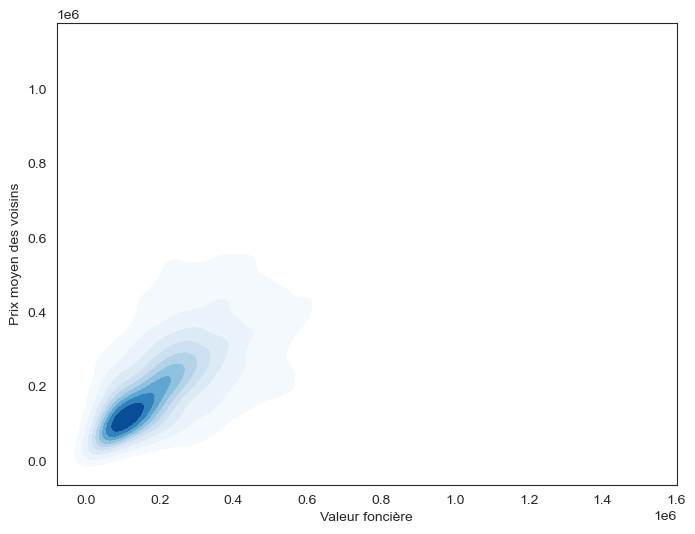

In [55]:
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df_final_clean['valeur_fonciere'], y=df_final_clean['prix_moyen_voisins'], cmap='Blues', fill=True)
plt.xlabel('Valeur foncière')
plt.ylabel('Prix moyen des voisins')
plt.show()

Il semble en outre que nous ayons créé une feature avec un pouvoir prédictif particulièrement fort!